/home/sakspari/Documents/magister/CVL/DeepFakeDetection/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


preparing dataset of lbp processed frames...


processing fake videos: 100%|██████████| 1000/1000 [53:25<00:00,  3.21s/it] 
/home/sakspari/Documents/magister/CVL/DeepFakeDetection/.venv/lib/python3.12/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


dataset prepared. train: 25592, val: 6399, test: 7998
initializing model with sta and convlstm
starting training for xception model with sta and convlstm...


epoch 1/30: 100%|██████████| 800/800 [06:31<00:00,  2.04it/s]


epoch 1/30, train loss: 0.2394, train acc: 89.60%, val loss: 0.1252, val acc: 95.20%
validation accuracy improved, saving best model to ./model_checkpoints_lbp/best_model_xception.pth


epoch 2/30: 100%|██████████| 800/800 [06:48<00:00,  1.96it/s]


epoch 2/30, train loss: 0.0491, train acc: 98.19%, val loss: 0.0968, val acc: 96.44%
validation accuracy improved, saving best model to ./model_checkpoints_lbp/best_model_xception.pth


epoch 3/30: 100%|██████████| 800/800 [06:53<00:00,  1.93it/s]


epoch 3/30, train loss: 0.0261, train acc: 99.06%, val loss: 0.1257, val acc: 95.73%
validation accuracy did not improve, counter: 1/5


epoch 4/30: 100%|██████████| 800/800 [06:55<00:00,  1.93it/s]


epoch 4/30, train loss: 0.0197, train acc: 99.29%, val loss: 0.1030, val acc: 96.78%
validation accuracy improved, saving best model to ./model_checkpoints_lbp/best_model_xception.pth


epoch 5/30: 100%|██████████| 800/800 [06:53<00:00,  1.94it/s]


epoch 5/30, train loss: 0.0177, train acc: 99.36%, val loss: 0.1028, val acc: 97.08%
validation accuracy improved, saving best model to ./model_checkpoints_lbp/best_model_xception.pth


epoch 6/30: 100%|██████████| 800/800 [06:55<00:00,  1.92it/s]


epoch 6/30, train loss: 0.0162, train acc: 99.45%, val loss: 0.1456, val acc: 95.98%
validation accuracy did not improve, counter: 1/5


epoch 7/30: 100%|██████████| 800/800 [06:57<00:00,  1.92it/s]


epoch 7/30, train loss: 0.0151, train acc: 99.49%, val loss: 0.0759, val acc: 97.50%
validation accuracy improved, saving best model to ./model_checkpoints_lbp/best_model_xception.pth


epoch 8/30: 100%|██████████| 800/800 [06:57<00:00,  1.91it/s]


epoch 8/30, train loss: 0.0115, train acc: 99.64%, val loss: 0.1099, val acc: 96.87%
validation accuracy did not improve, counter: 1/5


epoch 9/30: 100%|██████████| 800/800 [06:54<00:00,  1.93it/s]


epoch 9/30, train loss: 0.0130, train acc: 99.55%, val loss: 0.1028, val acc: 97.25%
validation accuracy did not improve, counter: 2/5


epoch 10/30: 100%|██████████| 800/800 [06:58<00:00,  1.91it/s]


epoch 10/30, train loss: 0.0107, train acc: 99.64%, val loss: 0.0864, val acc: 97.34%
validation accuracy did not improve, counter: 3/5


epoch 11/30: 100%|██████████| 800/800 [06:56<00:00,  1.92it/s]


epoch 11/30, train loss: 0.0101, train acc: 99.68%, val loss: 0.1522, val acc: 95.23%
validation accuracy did not improve, counter: 4/5


epoch 12/30: 100%|██████████| 800/800 [07:02<00:00,  1.89it/s]


epoch 12/30, train loss: 0.0109, train acc: 99.64%, val loss: 0.0846, val acc: 97.50%
validation accuracy did not improve, counter: 5/5
early stopping triggered

--- training finished ---


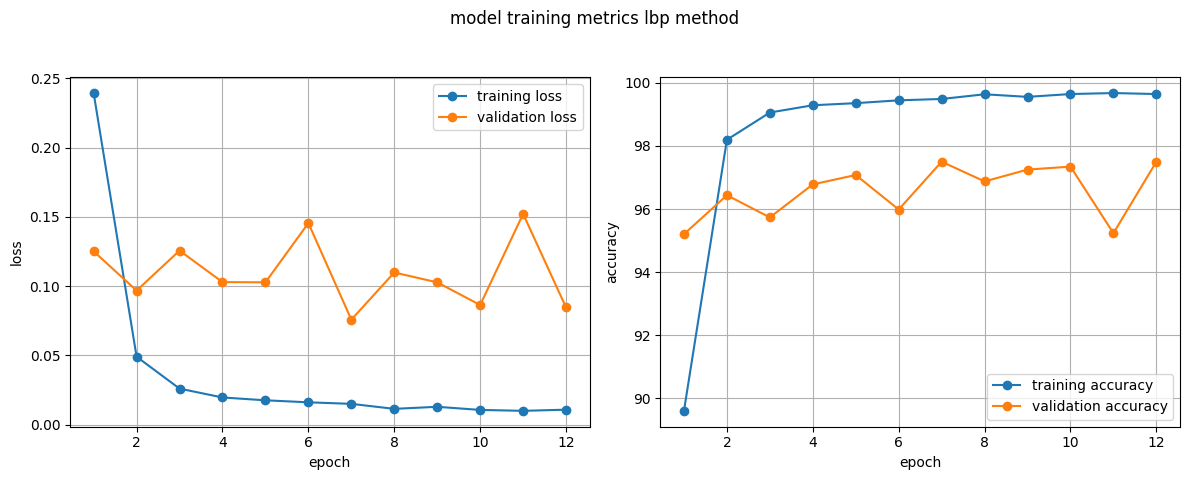

metrics plot saved to training_metrics_lbp.png

loading best model from ./model_checkpoints_lbp/best_model_xception.pth for final evaluation...


evaluating on test set: 100%|██████████| 250/250 [00:52<00:00,  4.80it/s]



--- test set evaluation ---
              precision    recall  f1-score   support

        real       0.98      0.98      0.98      4000
        fake       0.98      0.98      0.98      3998

    accuracy                           0.98      7998
   macro avg       0.98      0.98      0.98      7998
weighted avg       0.98      0.98      0.98      7998



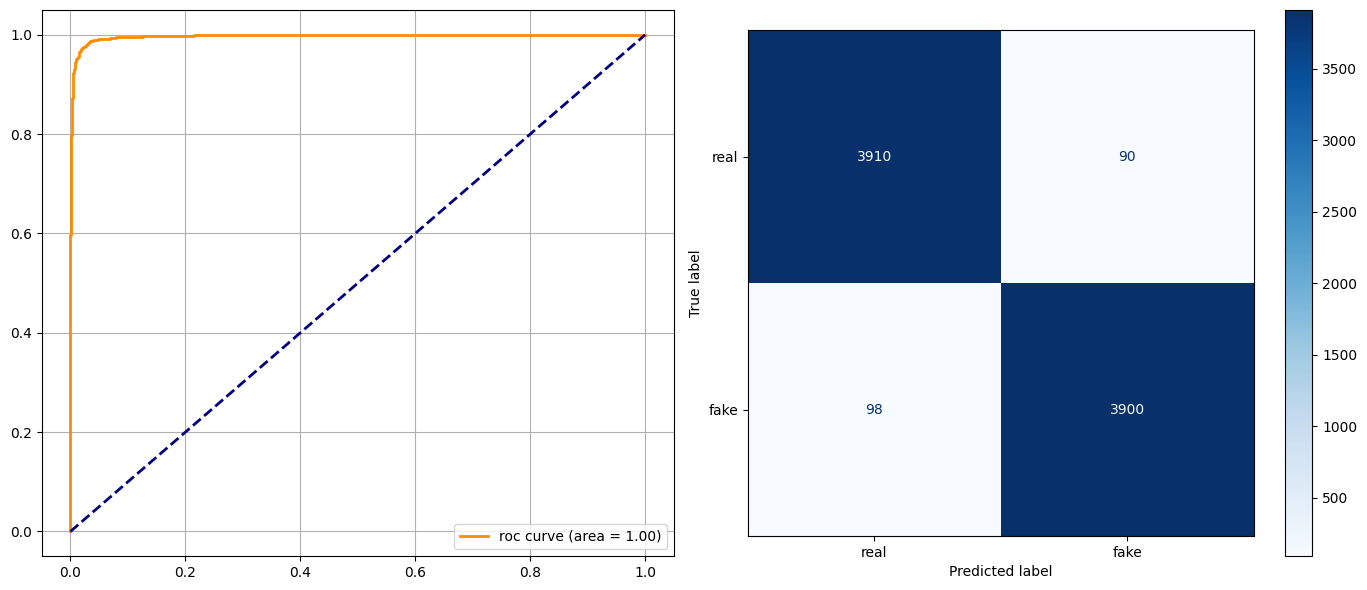

test evaluation plots saved to test_evaluation_results_lbp.png


In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy

# --- new dependencies ---
from facenet_pytorch import MTCNN
from skimage.feature import local_binary_pattern
import timm
import torch.nn.functional as F

# --- configuration ---
CONFIG = {
    "real_data_path": "./datasets/ff-c23/FaceForensics++_C23/original",
    "fake_data_path": "./datasets/ff-c23/FaceForensics++_C23/Deepfakes",
    "max_videos_per_class": 1000,
    "frames_per_video": 20,
    "image_size": 224,
    "batch_size": 32,
    "epochs": 30,
    "learning_rate": 1e-4,
    "seed": 42,
    "model_name": "xception",
    "model_save_path": "./model_checkpoints_lbp",
    "early_stopping_patience": 5,
    "weight_decay": 1e-5,
}

torch.manual_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- step 1: data preparation ---
mtcnn = MTCNN(keep_all=False, post_process=False, min_face_size=20, device=device)

def apply_gaussian_and_lbp(image):
    img_np_gray = np.array(image.convert('L'))
    img_blur = cv2.GaussianBlur(img_np_gray, (3, 3), 0)
    n_points = 24
    radius = 3
    lbp = local_binary_pattern(img_blur, n_points, radius, method='uniform')
    lbp = (lbp / np.max(lbp) * 255).astype(np.uint8)
    lbp_rgb = cv2.cvtColor(lbp, cv2.COLOR_GRAY2RGB)
    return Image.fromarray(lbp_rgb)

def prepare_frames_dataset(config):
    print("preparing dataset of lbp processed frames...")
    all_images = []
    all_labels = []

    def process_videos(video_paths, label, desc):
        for video_path in tqdm(video_paths, desc=desc):
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                continue
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            frame_indices = np.linspace(0, frame_count - 1, config["frames_per_video"], dtype=int)
            for i in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                ret, frame = cap.read()
                if not ret:
                    continue
                frame_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                face_tensor = mtcnn(frame_pil)
                if face_tensor is not None:
                    face_pil = transforms.ToPILImage()(face_tensor)
                    lbp_image = apply_gaussian_and_lbp(face_pil)
                    all_images.append(lbp_image)
                    all_labels.append(label)
            cap.release()

    real_videos = [os.path.join(config["real_data_path"], f) for f in os.listdir(config["real_data_path"])][:config["max_videos_per_class"]]
    process_videos(real_videos, 0, "processing real videos")
    fake_videos = [os.path.join(config["fake_data_path"], f) for f in os.listdir(config["fake_data_path"])][:config["max_videos_per_class"]]
    process_videos(fake_videos, 1, "processing fake videos")

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        all_images, all_labels, test_size=0.20, random_state=config["seed"], stratify=all_labels
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.20, random_state=config["seed"], stratify=y_train_val
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

# --- dataset ---
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return self.transform(image), torch.tensor(label, dtype=torch.long)

# --- spatiotemporal attention ---
class SpatiotemporalAttention(nn.Module):
    def __init__(self, in_channels=3):
        super(SpatiotemporalAttention, self).__init__()
        self.conv1x1 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.sa_conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.layer_norm = nn.LayerNorm(in_channels)
        self.relu = nn.ReLU()
        self.sa_conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.ta_q = nn.Linear(in_channels, in_channels)
        self.ta_k = nn.Linear(in_channels, in_channels)
        self.ta_v = nn.Linear(in_channels, in_channels)
    def forward(self, x):
        b, t, c, h, w = x.shape
        x_reshaped = x.view(b*t, c, h, w)
        am = self.conv1x1(x_reshaped)
        gf_intermediate = self.sa_conv1(am * x_reshaped)
        gf_intermediate = gf_intermediate.view(b*t, c, -1).transpose(1,2)
        gf_intermediate = self.layer_norm(gf_intermediate)
        gf_intermediate = gf_intermediate.transpose(1,2).view(b*t, c, h, w)
        gf = self.sa_conv2(self.relu(gf_intermediate))
        saf = x_reshaped + gf
        gf_pooled = F.adaptive_avg_pool2d(gf, (1,1)).view(b, t, c)
        q = self.ta_q(gf_pooled)
        k = self.ta_k(gf_pooled)
        v = self.ta_v(gf_pooled)
        attn = torch.bmm(q, k.transpose(1,2)) / (c ** 0.5)
        attn = F.softmax(attn, dim=-1)
        tf_matrix = torch.bmm(attn, v)
        tf = tf_matrix.view(b*t, c, 1, 1).expand(-1, -1, h, w)
        staf = saf * tf + x_reshaped
        return staf.view(b, t, c, h, w)

# --- convlstm cell ---
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size=3):
        super(ConvLSTMCell, self).__init__()
        padding = kernel_size // 2
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.conv = nn.Conv2d(input_dim + hidden_dim, 4 * hidden_dim, kernel_size, padding=padding)
    def forward(self, x, states):
        h, c = states
        combined = torch.cat([x, h], dim=1)
        conv_out = self.conv(combined)
        i, f, o, g = torch.split(conv_out, self.hidden_dim, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next
    def init_hidden(self, batch_size, spatial_size, device):
        h, w = spatial_size
        return (torch.zeros(batch_size, self.hidden_dim, h, w, device=device),
                torch.zeros(batch_size, self.hidden_dim, h, w, device=device))

# --- model sta + xception + convlstm ---
class STA_Xception_ConvLSTM(nn.Module):
    def __init__(self, model_name="xception", num_classes=2, hidden_dim=256):
        super(STA_Xception_ConvLSTM, self).__init__()
        self.sta = SpatiotemporalAttention(in_channels=3)
        base_model = timm.create_model(model_name, pretrained=True, num_classes=0, global_pool="")
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])
        feature_dim = base_model.num_features
        self.convlstm = ConvLSTMCell(input_dim=feature_dim, hidden_dim=hidden_dim, kernel_size=3)
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        if x.dim() == 4:
            x = x.unsqueeze(1)
        b, t, c, h, w = x.shape
        x = self.sta(x)
        h_state, c_state = None, None
        for i in range(t):
            frame_feat = self.backbone(x[:, i])
            if frame_feat.dim() == 2:
                frame_feat = frame_feat.unsqueeze(-1).unsqueeze(-1)
            if h_state is None:
                h_state, c_state = self.convlstm.init_hidden(b, (frame_feat.shape[2], frame_feat.shape[3]), frame_feat.device)
            h_state, c_state = self.convlstm(frame_feat, (h_state, c_state))
        out = self.gap(h_state).view(b, -1)
        out = self.fc(out)
        return out

def get_model(model_name, num_classes=2):
    print("initializing model with sta and convlstm")
    return STA_Xception_ConvLSTM(model_name=model_name, num_classes=num_classes)

# --- evaluation and plotting ---
def plot_and_save_metrics(train_loss, val_loss, train_acc, val_acc, save_path="training_metrics_lbp.png"):
    epochs_range = range(1, len(train_loss) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, 'o-', label='training loss')
    plt.plot(epochs_range, val_loss, 'o-', label='validation loss')
    plt.legend(loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_acc, 'o-', label='training accuracy')
    plt.plot(epochs_range, val_acc, 'o-', label='validation accuracy')
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid(True)
    plt.suptitle('model training metrics lbp method')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(save_path)
    plt.show()
    print(f"metrics plot saved to {save_path}")

def evaluate_on_test_set(model, test_loader, device):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="evaluating on test set"):
            images, labels = images.to(device), labels.to(device)
            if images.dim() == 4:
                images = images.unsqueeze(1)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            _, predicted = torch.max(outputs.data, 1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print("\n--- test set evaluation ---")
    print(classification_report(all_labels, all_preds, target_names=['real', 'fake']))
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'roc curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['real', 'fake'])
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.tight_layout()
    plt.savefig("test_evaluation_results_lbp.png")
    plt.show()
    print("test evaluation plots saved to test_evaluation_results_lbp.png")

# --- main execution ---
if __name__ == "__main__":
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_frames_dataset(CONFIG)
    print(f"dataset prepared. train: {len(X_train)}, val: {len(X_val)}, test: {len(X_test)}")

    data_transforms = transforms.Compose([
        transforms.Resize((CONFIG["image_size"], CONFIG["image_size"])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

    train_dataset = ImageDataset(X_train, y_train, data_transforms)
    val_dataset = ImageDataset(X_val, y_val, data_transforms)
    test_dataset = ImageDataset(X_test, y_test, data_transforms)

    train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=2, pin_memory=True)

    model = get_model(CONFIG["model_name"]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=CONFIG["weight_decay"])

    model_save_dir = CONFIG["model_save_path"]
    os.makedirs(model_save_dir, exist_ok=True)
    best_model_path = os.path.join(model_save_dir, f"best_model_{CONFIG['model_name']}.pth")

    train_loss_history, val_loss_history, train_acc_history, val_acc_history = [], [], [], []
    best_val_accuracy = 0
    epochs_no_improve = 0

    print(f"starting training for {CONFIG['model_name']} model with sta and convlstm...")
    for epoch in range(CONFIG["epochs"]):
        model.train()
        running_loss, train_correct, train_total = 0.0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"epoch {epoch+1}/{CONFIG['epochs']}"):
            images, labels = images.to(device), labels.to(device)
            if images.dim() == 4:
                images = images.unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * train_correct / train_total
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_train_acc)

        model.eval()
        val_correct, val_total, running_val_loss = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                if images.dim() == 4:
                    images = images.unsqueeze(1)
                outputs = model(images)
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_acc = 100 * val_correct / val_total
        epoch_val_loss = running_val_loss / len(val_loader)
        val_acc_history.append(epoch_val_acc)
        val_loss_history.append(epoch_val_loss)

        print(f"epoch {epoch+1}/{CONFIG['epochs']}, train loss: {epoch_loss:.4f}, train acc: {epoch_train_acc:.2f}%, val loss: {epoch_val_loss:.4f}, val acc: {epoch_val_acc:.2f}%")

        if epoch_val_acc > best_val_accuracy:
            best_val_accuracy = epoch_val_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"validation accuracy improved, saving best model to {best_model_path}")
        else:
            epochs_no_improve += 1
            print(f"validation accuracy did not improve, counter: {epochs_no_improve}/{CONFIG['early_stopping_patience']}")

        if epochs_no_improve >= CONFIG['early_stopping_patience']:
            print("early stopping triggered")
            break

    print("\n--- training finished ---")
    plot_and_save_metrics(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

    print(f"\nloading best model from {best_model_path} for final evaluation...")
    model.load_state_dict(torch.load(best_model_path))
    evaluate_on_test_set(model, test_loader, device)
